In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                       Data Science Salaries 2023  💸                 25KB  2023-04-13 09:55:16           5971        147  1.0              
salvatorerastelli/spotify-and-youtube                       Spotify and Youtube                            9MB  2023-03-20 15:43:25          11516        403  1.0              
iammustafatz/diabetes-prediction-dataset                    Diabetes prediction dataset                  734KB  2023-04-08 06:11:45           3067         52  1.0              
shawkyelgendy/furniture-price-prediction                    Furniture Price Prediction                    81KB  202

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:53<00:00, 160MB/s]
100% 6.31G/6.31G [00:53<00:00, 127MB/s]


In [ ]:
import zipfile
import pandas as pd

# Extract the csv file from the zip file
with zipfile.ZipFile('/content/histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./')


In [ ]:
labels_df = pd.read_csv('/content/train_labels.csv')
labels_df.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [ ]:
malignant = []
normal = []

for index, row in labels_df.iterrows():
    if row['label'] == 1:
        malignant.append(row['id'])
    else:
        normal.append(row['id'])

normal[0:10]

['f38a6374c348f90b587e046aac6079959adf3835',
 '755db6279dae599ebb4d39a9123cce439965282d',
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08',
 '068aba587a4950175d04c680d38943fd488d6a9d',
 'acfe80838488fae3c89bd21ade75be5c34e66be7',
 '559e55a64c9ba828f700e948f6886f4cea919261',
 '8eaaa7a400aa79d36c2440a4aa101cc14256cda4',
 'a106469bbfda4cdc5a9da7ac0152927bf1b4a92d',
 'a1991e73a9b676faddd2bd47c39754b14d1eb923',
 '08566ce82d4406f464c9c2a3cd014704735db7a9']

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'

Text(0.5, 0.94, 'Normal')

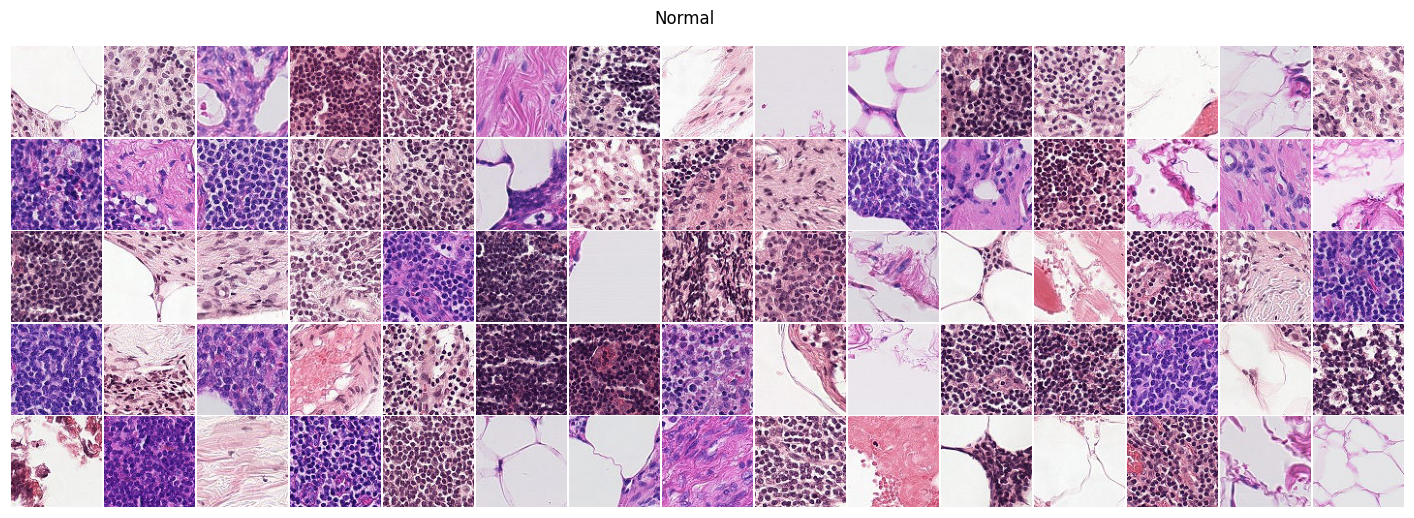

In [ ]:
from matplotlib import pyplot as plt
import os
from PIL import Image, ImageDraw
import numpy as np
title = "Normal"
nrows = 5
ncols = 15

fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
plt.subplots_adjust(wspace=0, hspace=0)

for i,j in enumerate(normal[:nrows*ncols]):
    fname = os.path.join(train_dir ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='white')
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(np.array(img))
    plt.axis('off')

plt.suptitle(title, y=0.94)


In [ ]:
from sklearn.model_selection import train_test_split
stratified_sampled, _ = train_test_split(labels_df, stratify=labels_df.label, train_size=0.1)
stratified_sampled.to_csv('/content/stratified_sampled.csv')

In [ ]:
import shutil
source = train_dir
destination = '/content/Stratified_train'
for i in stratified_sampled['id']:
  shutil.copy(os.path.join(source,i+'.tif'), destination)

In [ ]:
import os
import pandas as pd
from PIL import Image


# Load the train labels
train_labels = pd.read_csv('/content/stratified_sampled.csv')
# train_labels = labels_df
# Define the image size and channels
img_size = 128
channels = 1

batch_size = 1000
# Define the function to read the images and return a pandas dataframe
def read_images(directory, labels, batch_size):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            # Load the image and resize it
            img = Image.open(os.path.join(directory, filename)).convert('L')
            img = img.resize((img_size, img_size), Image.ANTIALIAS)
            # Flatten the image and append the label and id
            img_arr = pd.Series(list(img.getdata()))
            img_arr['id'] = os.path.splitext(filename)[0]
            # print(labels )
            img_arr['label'] = labels[labels['id'] == img_arr['id']]['label'].values[0]
            images.append(img_arr)
        if len(images) == batch_size or i == len(os.listdir(directory)) - 1:
            df = pd.DataFrame(images)
            images = []
            yield df
    return pd.DataFrame(images)

# Read the train and test images and merge them on id
train_images = pd.concat([df for df in read_images(destination,train_labels, batch_size)], ignore_index=True, sort=False)

# test_images = read_images(test_dir, pd.DataFrame({'id': os.listdir(test_dir)}))
# images = pd.concat([train_images, test_images], ignore_index=True, sort=False)

# Rearrange the columns to have id at the last column
columns = train_images.columns.tolist()
columns.remove('id')
columns.remove('label')
columns.append('id')
columns.append('label')
images = train_images[columns]

images.to_csv('/content/Image_to_feature_data.csv')
# Print the first few rows of the dataframe
print(images.head())


     0    1    2    3    4    5    6    7    8    9  ...  16376  16377  16378  \
0   83  132  158  120   99   69   55   55   47   66  ...    213    209    198   
1   41   53   51   64  136  205  146   35   43   50  ...    197    221    186   
2  249  249  248  247  246  246  247  248  249  250  ...    248    248    248   
3  136  139  190  250  252  185  149  153  122  120  ...    206    210    203   
4  248  248  248  248  248  248  248  248  248  248  ...    247    247    247   

   16379  16380  16381  16382  16383  \
0    216    189    121     82     90   
1    145    197    204    200    210   
2    248    248    248    246    246   
3    187    197    220    211    191   
4    247    247    247    247    247   

                                         id  label  
0  b7c674519578f8177928734ee099851e797a7440      0  
1  f6e72bccfd0d5b142206481f65c6b2153f857403      0  
2  1883398b671745dc26afa881f43746bc2e7e7e98      0  
3  d782b2c66461257ae0981aa866741c70f0907594      1  
4  8bc3

In [ ]:
images.shape

(22000, 16386)

In [ ]:
images.head()

,0,1,2,3,4,5,6,7,8,9,...,16376,16377,16378,16379,16380,16381,16382,16383,id,label
0,83,132,158,120,99,69,55,55,47,66,...,213,209,198,216,189,121,82,90,b7c674519578f8177928734ee099851e797a7440,0
1,41,53,51,64,136,205,146,35,43,50,...,197,221,186,145,197,204,200,210,f6e72bccfd0d5b142206481f65c6b2153f857403,0
2,249,249,248,247,246,246,247,248,249,250,...,248,248,248,248,248,248,246,246,1883398b671745dc26afa881f43746bc2e7e7e98,0
3,136,139,190,250,252,185,149,153,122,120,...,206,210,203,187,197,220,211,191,d782b2c66461257ae0981aa866741c70f0907594,1
4,248,248,248,248,248,248,248,248,248,248,...,247,247,247,247,247,247,247,247,8bc388c83523d3246b426d0848b0c58329154c18,0


In [ ]:
ids = images['id']
labels = images['label']

X = images.drop(['id', 'label'], axis=1).to_numpy()
y= labels


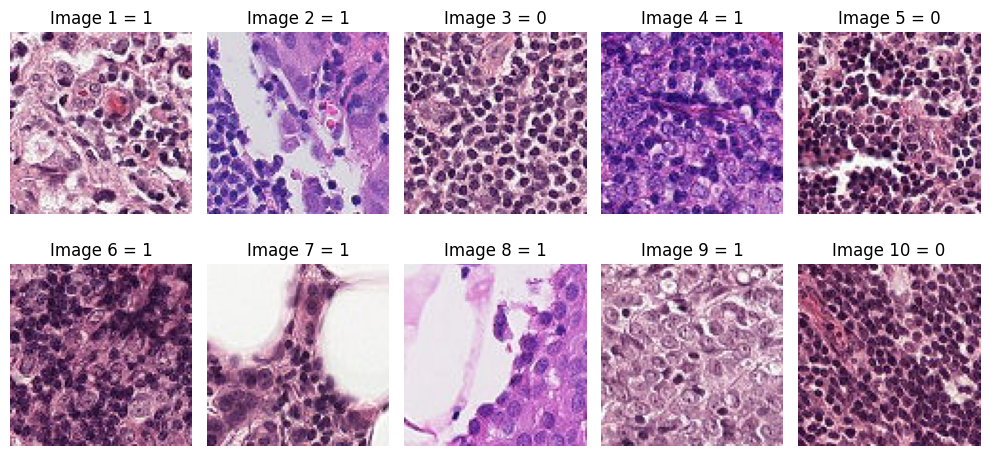

In [ ]:
indices = np.random.choice(len(images), 10, replace=False)

# Plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()
for i, idx in enumerate(indices):
    img_id = images.loc[idx, 'id']
    img_label = images.loc[idx, 'label']
    img = Image.open(f'train/{img_id}.tif')
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"Image {i+1} = {img_label}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.decomposition import PCA
# #n_components=0.80 means it will return the Eigenvectors that have the 80% of the variation in the dataset
# pca = PCA(n_components=0.8)
# pca.fit_transform(X)
# fig, axes = plt.subplots(2,10,figsize=(9,3),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.01, wspace=0.01))
# for i, ax in enumerate(axes.flat):
#  ax.imshow(pca.components_[i].reshape(128,128))

In [ ]:
from google.colab import files
files.download('/content/Image_to_feature_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/output.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  images.to_csv(f)

Mounted at /content/drive
